In [2]:
import re
import glob
import pandas as pd
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## 데이터 불러오기

In [3]:
lst_file1 = glob.glob('./valid/label_실제도로환경/*/*/*')
lst_file2 = glob.glob('./valid/label_준통제환경/*/*')
lst_file3 = glob.glob('./valid/label_통제환경/*/*')
lst_img1 = glob.glob('./valid/data_realenv/*/*/*')
lst_img2 = glob.glob('./valid/data_semienv/*/*')
lst_img3 = glob.glob('./valid/data_ctrlenv/*/*')

In [12]:
lst_file1 = glob.glob('./train/label_실제도로환경/*/*/*')
lst_file2 = glob.glob('./train/label_준통제환경/*/*')
lst_file3 = glob.glob('./train/label_통제환경/*/*')
lst_img1 = glob.glob('./train/data_realenv/*/*/*')
lst_img2 = glob.glob('./train/data_semienv/*/*')
lst_img3 = glob.glob('./train/data_ctrlenv/*/*')

In [13]:
lst_file_total = [lst_file1,lst_file2,lst_file3]
lst_img_total = [lst_img1,lst_img2,lst_img3]

## 불러온 데이터에 대하여 클래스 판단하기
    - 눈을 감고 있거나 입을 벌리고 있을 경우, '위험'
    - 담배나 핸드폰을 갖고 있을 경우, '주의'
    - 나머지는 정상

In [14]:
import json

cols = ['img_name', 'eye_left', 'eye_right','mouth','cigar','phone','img_path']
lst_df = []
for paths, imgs in tqdm(zip(lst_file_total,lst_img_total)):
    lst_path = paths
    lst_img = imgs
    lst_data = []
    for file1, file2 in zip(lst_path,lst_img):
        try:
            with open(file1, encoding='utf-8', errors='ignore') as json_file:
                json_data = json.load(json_file)

            img_name = json_data['FileInfo']['FileName']
            eye_left = json_data['ObjectInfo']['BoundingBox']['Leye']['Opened']
            eye_right = json_data['ObjectInfo']['BoundingBox']['Reye']['Opened']
            mouth = json_data['ObjectInfo']['BoundingBox']['Mouth']['Opened']
            cigar = json_data['ObjectInfo']['BoundingBox']['Cigar']['isVisible']
            phone = json_data['ObjectInfo']['BoundingBox']['Phone']['isVisible']

            lst_data.append([img_name,eye_left,eye_right,mouth,cigar,phone,file2])
        except:
            print("file not exist.")
    df_label_info = pd.DataFrame(lst_data, columns=cols)
    
    
    lst_df.append(df_label_info)
df_total = pd.concat(lst_df, axis=0)

def determine_label(x):
    
    if x.cigar == True or x.phone == True:
        label = 1
    elif x.mouth == True:
        label = 2
    elif x.eye_left == False and x.eye_right == False:
        label = 2
    else:
        label = 0
    return label

df_total['label'] = df_total.apply(lambda x: determine_label(x), axis=1)

3it [01:07, 22.66s/it]


## 데이터의 크기를 조정하고 정규화 진행

In [17]:
images = []
labels = []
for file,label in zip(df_total['img_path'].values,df_total['label'].values):

    # 이미지들의 크기를 모델에 맞게 조정
    IMAGE_SIZE = (100, 100)
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE) 

    # 이미지 데이터와 그에 맞는 클래스들을 각 리스트에 취합
    images.append(image)
    labels.append(label)
        
train_images = np.array(images, dtype = 'float32')
train_labels = np.array(labels, dtype = 'int32')   
#test_images = np.array(images, dtype = 'float32')
#test_labels = np.array(labels, dtype = 'int32')       


In [25]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

## 데이터의 분포 파악

In [18]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))

Number of training examples: 30000
Number of testing examples: 14999


<Figure size 1440x1080 with 0 Axes>

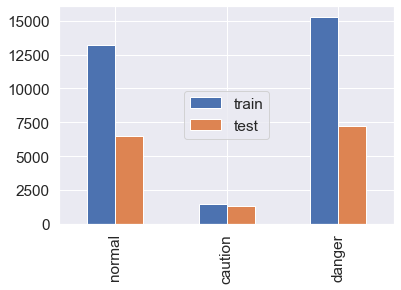

In [22]:
import pandas as pd
plt.figure(figsize=(20,15))
class_names=['normal','caution','danger']
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.legend(loc='center')
plt.show()

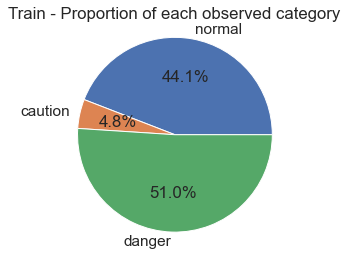

In [23]:
plt.pie(train_counts,
        explode=(0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Train - Proportion of each observed category')
plt.show()

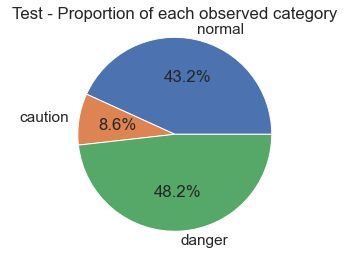

In [24]:
plt.pie(test_counts,
        explode=(0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Test - Proportion of each observed category')
plt.show()

## 모델 구성

In [14]:
# example of tending the vgg16 model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
# load model without classifier layers
model = VGG16(include_top=False, input_shape=(224, 224, 3))
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [36]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (100, 100, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

## 모델 학습 및 예측

In [57]:
model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, batch_size=100, 
                    epochs=10)

Epoch 1/10
300/300 [==============================] - 49s 162ms/step - loss: 0.0530 - accuracy: 0.9794
Epoch 2/10
300/300 [==============================] - 49s 162ms/step - loss: 0.0426 - accuracy: 0.9844
Epoch 3/10
300/300 [==============================] - 48s 161ms/step - loss: 0.0376 - accuracy: 0.9862
Epoch 4/10
300/300 [==============================] - 48s 161ms/step - loss: 0.0348 - accuracy: 0.9875
Epoch 5/10
300/300 [==============================] - 48s 161ms/step - loss: 0.0286 - accuracy: 0.9896
Epoch 6/10
300/300 [==============================] - 48s 161ms/step - loss: 0.0255 - accuracy: 0.9914
Epoch 7/10
300/300 [==============================] - 48s 161ms/step - loss: 0.0253 - accuracy: 0.9913
Epoch 8/10
300/300 [==============================] - 48s 162ms/step - loss: 0.0234 - accuracy: 0.9920
Epoch 9/10
300/300 [==============================] - 48s 161ms/step - loss: 0.0230 - accuracy: 0.9925
Epoch 10/10
300/300 [==============================] - 48s 161ms/step - l

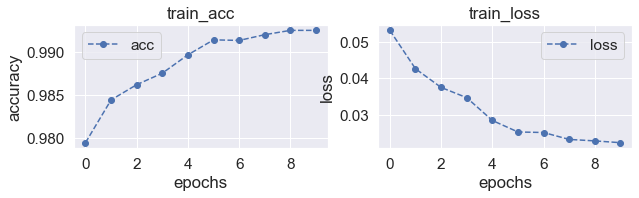

In [58]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    #plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc")# vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    #plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss")# vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
    
plot_accuracy_loss(history)

In [59]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

## 예측 결과

In [60]:
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))
print("Precision : {}".format(precision_score(test_labels, pred_labels, average="macro")))
print("Recall : {}".format(recall_score(test_labels, pred_labels, average="macro")))
print("F1-score : {}".format(f1_score(test_labels, pred_labels, average="macro")))

Accuracy : 0.6225748383225549
Precision : 0.5810438918162152
Recall : 0.6386760894885951
F1-score : 0.593739503361571


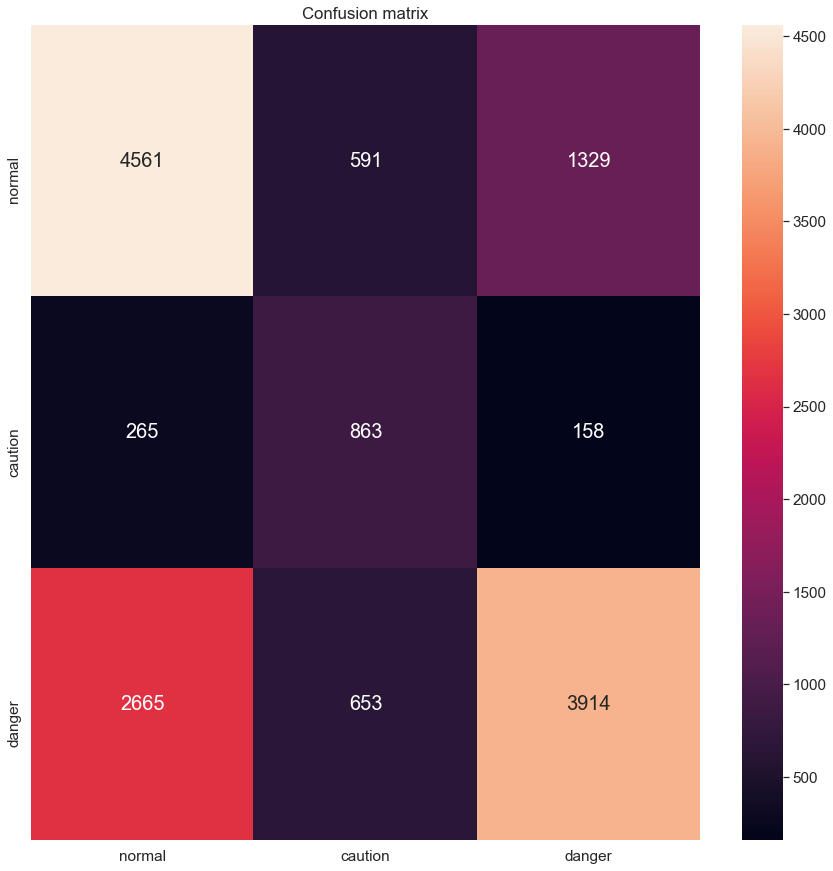

In [61]:
CM = confusion_matrix(test_labels, pred_labels)
plt.figure(figsize=(15,15))
ax = plt.axes()
sn.heatmap(CM, annot=True, fmt='.5g', 
           annot_kws={"size": 20}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()